I believe there is a way to pipe files directly from https://database.lichess.org/

They mention using $zstdcat lichess_db.pgn.zst | python script.py to pipe from compressed file to script

Total download size is 1.5 TB which we could technically download...

In [133]:
#Import libraries and initialize global variables
import pandas as pd

csv_path = 'Data/chessgames-2013-01.csv'
pgn_path = 'Data/lichess_db_standard_rated_2013-01.pgn'
svg_size = 8*10 #multiple of 8 guarantees each square on the board is the same size

In [134]:
#helper methods for initialization
import chess.pgn
from time import perf_counter

def remove_tournament_url(str):
    """
    splits str based on whitespace and removes the final item if it begins with 'https'
    """
    lst = str.split()
    if lst[-1][:5] == 'https':
        return ' '.join(lst[:-1])
    else:
        return str

def load_pgn(path):
    """
    returns a DataFrame with data loaded from pgn file at 'path'
    """
    start = perf_counter()
    pgn = open(path)
    i = 0
    result = []
    while(True):
        game = chess.pgn.read_game(pgn)
        if game:
            if not game.errors:
                event = remove_tournament_url(game.headers['Event'])
                id = (game.headers['Site'][-8:])
                gameresult = (game.headers['Result'])
                whiteelo = (game.headers['WhiteElo'])
                blackelo = (game.headers['BlackElo'])
                timecontrol = (game.headers['TimeControl'])
                termination = (game.headers['Termination'])
                moves = (str(game.mainline_moves()))
                nummoves = (game.end().ply())
                result.append({'Event':event,'ID':id,'Result':gameresult,'WhiteElo':whiteelo,'BlackElo':blackelo,'TimeControl':timecontrol,'Termination':termination,'Moves':moves,'NumMoves':nummoves})
            i = i+1
            if(i%10000==0):
                print(i)
        else:
            break
    pgn.close()
    df = pd.DataFrame(result)
    stop = perf_counter()
    print(f'total time to load PGN into df: {stop-start}\ngames loaded:{len(df)}')
    return df

def drop_missing_elo(df):
    """
    drops rows of DataFrame where 'WhiteElo' or 'BlackElo' equals '?'
    """
    len_before = len(df)
    df = df.drop(df[df['WhiteElo'] == '?'].index)
    df = df.drop(df[df['BlackElo'] == '?'].index)
    len_after = len(df)
    print(f'dropped {len_before-len_after} games with missing Elos')
    return df

def result_to_int(str):
    """
    converts result to 1 if white won, -1 if black won, and 0 if draw
    """
    if str == '1-0':
        return 1
    elif str == '0-1':
        return -1
    elif str == '1/2-1/2':
        return 0
    else:
        return None
        
def remap_result_col(df):
    """
    calls result_to_int for each item in df['Result']
    """
    df['Result'] = df['Result'].map(result_to_int)
    return df
    
def update_chess_dtypes(df):
    """
    converts each DataFrame column to the correct dtype
    """
    df['Event'] = df['Event'].astype("string")
    df['ID'] = df['ID'].astype("string")
    df['Result']  = df['Result'].astype("Int8")
    df['WhiteElo'] = df['WhiteElo'].astype("Float32")
    df['BlackElo'] = df['BlackElo'].astype("Float32")
    df['TimeControl'] = df['TimeControl'].astype("string")
    df['Termination'] = df['Termination'].astype("string")
    df['Moves'] = df['Moves'].astype("string")
    df['NumMoves'] = df['NumMoves'].astype("UInt16") 
    return df

In [135]:
#load data into df if it exists else create it from pgn file
import os

if os.path.isfile(csv_path):
    df = pd.read_csv(csv_path,index_col=0)
    df = update_chess_dtypes(df)
    print(f'loaded {csv_path} into df')
elif os.path.isfile(pgn_path):
    df = load_pgn(pgn_path)
    df = drop_missing_elo(df)
    df = remap_result_col(df)
    df = update_chess_dtypes(df)
    df.to_csv(csv_path)
    print(f'df saved to {csv_path}')
else:
    raise(Exception('No valid path found'))

loaded Data/chessgames-2013-01.csv into df


In [136]:
df.head()

,Event,ID,Result,WhiteElo,BlackElo,TimeControl,Termination,Moves,NumMoves
0,Rated Classical game,j1dkb5dw,1,1639.0,1403.0,600+8,Normal,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8#,25
1,Rated Classical game,a9tcp02g,1,1654.0,1919.0,480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nxg6 hxg6 6. Nd2 e6 7. Bd3 Bd6 8. e4 dxe4 9. Nxe4 Rxh2 10. Ke2 Rxh1 11. Qxh1 Nc6 12. Bg5 Ke7 13. Qh7 Nxd4+ 14. Kd2 Qe8 15. Qxg7 Qh8 16. Bxf6+ Kd7 17. Qxh8 Rxh8 18. Bxh8,35
2,Rated Classical game,szom2tog,1,1643.0,1747.0,420+17,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a3 Bxf2+ 6. Kxf2 Nd4 7. d3 Ng4+ 8. Kf1 Qf6 9. h3 d5 10. Nxd5 Qe6 11. Nxc7+,21
3,Rated Bullet game,rklpc7mk,-1,1824.0,1973.0,60+1,Normal,1. e4 c6 2. Nc3 d5 3. Qf3 dxe4 4. Nxe4 Nd7 5. Bc4 Ngf6 6. Nxf6+ Nxf6 7. Qg3 Bf5 8. d3 Bg6 9. Ne2 e6 10. Bf4 Nh5 11. Qf3 Nxf4 12. Nxf4 Be7 13. Bxe6 fxe6 14. Nxe6 Qa5+ 15. c3 Qe5+ 16. Qe3 Qxe3+ 17. fxe3 Kd7 18. Nf4 Bd6 19. Nxg6 hxg6 20. h3 Bg3+ 21. Kd2 Raf8 22. Rhf1 Ke7 23. d4 Rxf1 24. Rxf1 Rf8 25. Rxf8 Kxf8 26. e4 Ke7 27. Ke3 g5 28. Kf3 Be1 29. Kg4 Bd2 30. Kf5 Bc1 31. Kg6 Kf8 32. e5 Bxb2 33. Kxg5 Bxc3 34. h4 Bxd4 35. h5 Bxe5 36. g4 Bb2 37. Kf5 Kf7 38. g5 Bc1 39. g6+ Ke7 40. Ke5 b5 41. Kd4 Kd6 42. Kc3 c5 43. a3 Bg5 44. a4 bxa4 45. Kb2 Kd5 46. Ka3 Kd4 47. Kxa4 c4,94
4,Rated Bullet game,1xb3os63,-1,1765.0,1815.0,60+1,Normal,1. e4 e6 2. f4 d5 3. e5 c5 4. Nf3 Qb6 5. c3 Nc6 6. d3 Bd7 7. Be2 Nh6 8. O-O Nf5 9. g4 Nh6 10. Kg2 Nxg4 11. h3 Nh6 12. Ng5 Nf5 13. Bg4 Nce7 14. Nd2 Ne3+ 15. Kf3 Nxd1 16. Rxd1 h6 17. Nxf7 Kxf7 18. Rf1 h5 19. Bxe6+ Bxe6 20. Kg3 Nf5+ 21. Kg2 Ne3+ 22. Kf2 Nxf1 23. Kxf1 Bxh3+,46


array([[<Axes: title={'center': 'WhiteElo'}>]], dtype=object)

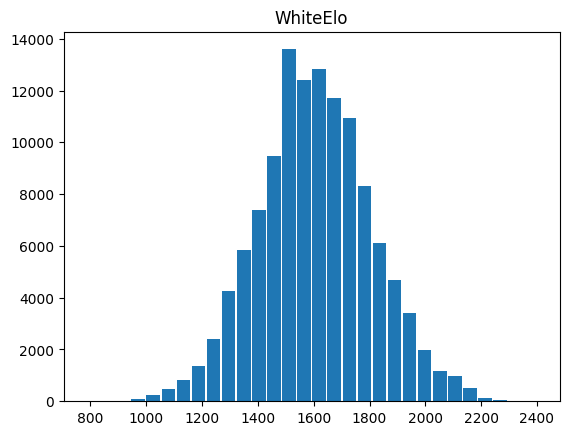

In [137]:
df.hist(column='WhiteElo',bins=30,rwidth=0.9, grid=False)

array([[<Axes: title={'center': 'BlackElo'}>]], dtype=object)

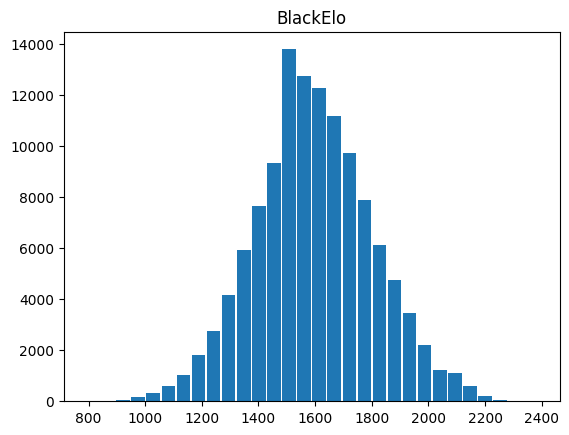

In [138]:
df.hist(column='BlackElo',bins=30,rwidth=0.9, grid=False)

array([[<Axes: title={'center': 'NumMoves'}>]], dtype=object)

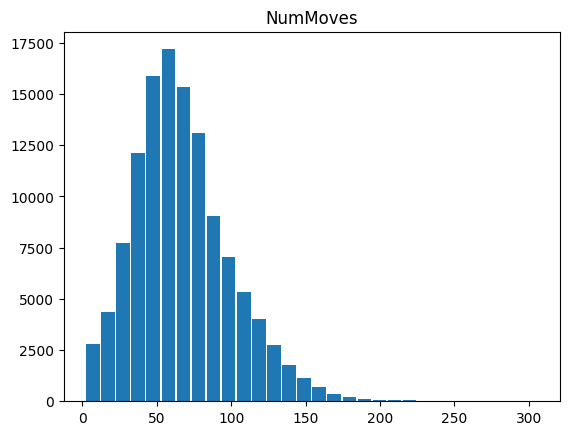

In [139]:
df.hist(column='NumMoves',bins=30,rwidth=0.9, grid=False)

In [140]:
print(f"{min(df['WhiteElo'])} <= White ELO <= {max(df['WhiteElo'])}\n{min(df['BlackElo'])} <= Black ELO <= {max(df['BlackElo'])}")

782.0 <= White ELO <= 2403.0
789.0 <= Black ELO <= 2386.0


In [1]:
from IPython.display import clear_output
import cairosvg
import io
import os


def watch_game(moves):
    """
    given a string of moves displays and updates the board every time the user presses enter
    """
    moves = io.StringIO(moves)
    game = chess.pgn.read_game(moves)
    board = game.board()
    display(board)
    for move in game.mainline_moves():
        input()
        clear_output()
        board.push(move)
        display(board)

def board_png_from_row(row, num_moves):
    """
    given a row entry from df and the move number
    saves a png (size: svg_size x svg_size) of the position to ./Data/PNGImages
    """
    if num_moves > row['NumMoves']:
        raise(Exception(f"num_moves exceeds maximum moves:{row['NumMoves']}"))
    png_path = f"Data/PGNImages/{row['ID']}_{row['WhiteElo']}_{row['BlackElo']}_{num_moves}.png"
    if not os.path.isfile(png_path):
        moves = io.StringIO(row['Moves'])
        game = chess.pgn.read_game(moves)
        board = game.board()
        iter = game.mainline_moves().__iter__()
        #+1 prevents us from generating default board
        for _ in range(num_moves+1):
            board.push(next(iter))
        cairosvg.svg2png(chess.svg.board(board, coordinates=False, size=svg_size),write_to=png_path)
    #In hindsight we really should create a method to generate all of the moves from a given row rather than calling this method on every move

def board_png_from_fen(fen):
    """
    TODO
    given a fen string
    saves a png (size: svg_size x svg_size) of the position to ./Data/FENImages
    """
    return None

In [142]:
def generate_full_game(row):
    for i in range(row['NumMoves']):
        board_png_from_row(row, i)
        
def generate_all_games():
    for j in range(len(df)):
        generate_full_game(df.iloc[j])
        print(f'completed row {j}/{len(df)}',end='\r')

In [143]:
##jupyter has issues with multiprocessing library. 
##We export the script to a .py file 
##and then run it in the notebook

script = """import pandas as pd
import os
import cairosvg
import chess.pgn
import chess.svg
import io
from multiprocessing import Pool

def update_chess_dtypes(df):

    #converts each DataFrame column to the correct dtype

    df['Event'] = df['Event'].astype("string")
    df['ID'] = df['ID'].astype("string")
    df['Result']  = df['Result'].astype("Int8")
    df['WhiteElo'] = df['WhiteElo'].astype("UInt16")
    df['BlackElo'] = df['BlackElo'].astype("UInt16")
    df['TimeControl'] = df['TimeControl'].astype("string")
    df['Termination'] = df['Termination'].astype("string")
    df['Moves'] = df['Moves'].astype("string")
    df['NumMoves'] = df['NumMoves'].astype("UInt16") 
    return df

def board_png_from_row(row, num_moves):

    #given a row entry from df and the move number
    #saves a png (size: svg_size x svg_size) of the position to ./Data/PNGImages

    if num_moves > row['NumMoves']:
        raise(Exception(f"num_moves exceeds maximum moves:{row['NumMoves']}"))
    png_path = f"Data/PGNImages/{row['ID']}_{row['WhiteElo']}_{row['BlackElo']}_{num_moves}.png"
    if not os.path.isfile(png_path):
        moves = io.StringIO(row['Moves'])
        game = chess.pgn.read_game(moves)
        board = game.board()
        iter = game.mainline_moves().__iter__()
        #+1 prevents us from generating default board
        for _ in range(num_moves+1):
            board.push(next(iter))
        cairosvg.svg2png(chess.svg.board(board, coordinates=False, size=8*10),write_to=png_path)

def generate_full_game(row):
    for i in range(row['NumMoves']):
        board_png_from_row(row, i)

def generate_all_games(iterrow_tuple):
	idx = iterrow_tuple[0]
	#print(f'row {idx}',end='\\r')
	row = iterrow_tuple[1]
	generate_full_game(row)
    
if __name__ == '__main__':
	if os.path.isfile('Data/chessgames-2013-01.csv'):
		df = pd.read_csv('Data/chessgames-2013-01.csv',index_col=0)
		df = update_chess_dtypes(df)
		print(f'loaded Data/chessgames-2013-01.csv into df')
	with Pool(6) as p:
		p.map(generate_all_games, df.iterrows())"""
with open("generate_all_games_script.py","w") as f:
    f.write(script)

In [144]:
###uncomment line below to generate images
###WARNING this will take a long time and use ~30GB of storage

#!"generate_all_games_script.py"

###TODO is there a good way to compress these together? 
###Many files are using 5kb out of 8kb block lots of wasted space

In [145]:
from fastai.vision.all import *
import torch
import pathlib

#Data has been created time to make our model!

def get_chess_path(row):
    return pathlib.Path(f"Data/PGNImages/{row['ID']}_{int(row['WhiteElo'])}_{int(row['BlackElo'])}_39.png")
def get_chess_images(df):
    return df.apply(get_chess_path, axis=1).tolist()
    
def white_elo(x):
    return float(x.name[:-4].split('_')[1])
    
board_block = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_chess_images,
    splitter=RandomSplitter(valid_pct=0.125, seed=42),
    get_y=white_elo
    )

In [146]:
df_classical_turn_20 = df[((df['Event'] == "Rated Classical tournament") | (df['Event'] == "Rated Classical game")) & (df['NumMoves'] >= 40)]
dls = board_block.dataloaders(df_classical_turn_20)

torch.cuda.empty_cache()
learn = vision_learner(dls, models.resnet34, n_out=1, loss_func=mse,y_range=(700.0,2500.0))
learn.cuda()
learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,49457.246094,35711.085938,00:51


epoch,train_loss,valid_loss,time
0,33200.281250,37245.757812,00:50
1,30292.804688,29608.296875,00:50
2,25394.501953,29611.537109,00:50


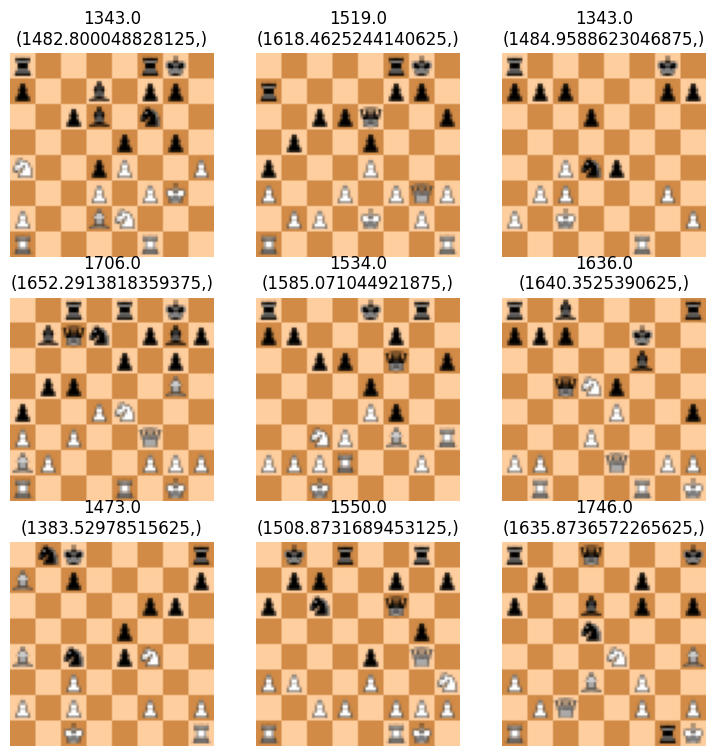

In [147]:
learn.show_results()

In [148]:
torch.cuda.empty_cache()
learn = vision_learner(dls, models.resnet34, n_out=1, loss_func=mse,y_range=(700.0,2500.0))
learn.cuda()
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,219739.718750,90923.414062,00:49
1,44588.238281,34172.554688,00:49
2,34924.203125,32391.208984,00:50
3,32631.271484,32254.845703,00:49
4,31854.542969,32142.320312,00:49
5,29663.791016,30248.066406,00:50
6,28242.527344,30415.005859,00:54
7,27349.861328,29869.423828,00:51
8,26356.371094,29817.099609,00:47
9,25646.251953,29812.654297,00:49


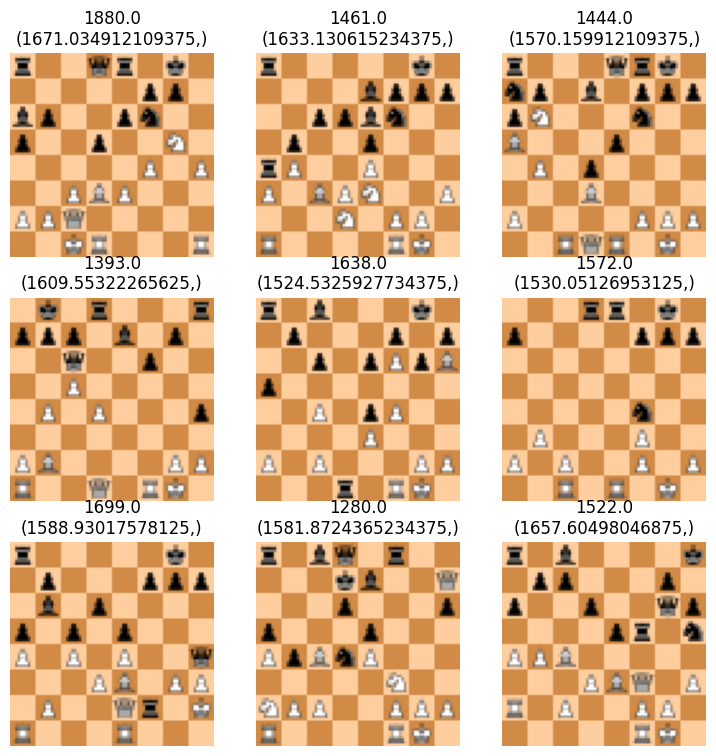

In [149]:
learn.show_results()

In [199]:
preds =learn.get_preds()

df_valid = pd.DataFrame()
df_valid['Path'] = [f.name for f in dls.valid_ds.items]
df_valid['Prediction'] = [float(x) for x in preds[0]]
df_valid['Target'] = [float(x) for x in preds[1]]
df_valid['Square Error'] = [(float(preds[0][i])-float(preds[1][i]))**2 for i in range(len(preds[0]))]
#df_valid['Pred'] = [learn.predict(f) for f in dls.valid_ds.items]
df_valid.head()

,Path,Prediction,Target,Square Error
0,dr55c2w0_1378_1270_39.png,1327.333008,1378.0,2567.144097
1,pa4a4w7h_1702_1787_39.png,1574.490479,1702.0,16258.678069
2,p3vyq2t7_1754_1832_39.png,1663.654541,1754.0,8162.301959
3,5dtunyc2_1368_1330_39.png,1658.034546,1368.0,84120.037815
4,3vs6d2m0_1706_1600_39.png,1512.778198,1706.0,37334.664675


array([[<Axes: title={'center': 'Target'}>,
        <Axes: title={'center': 'Prediction'}>]], dtype=object)

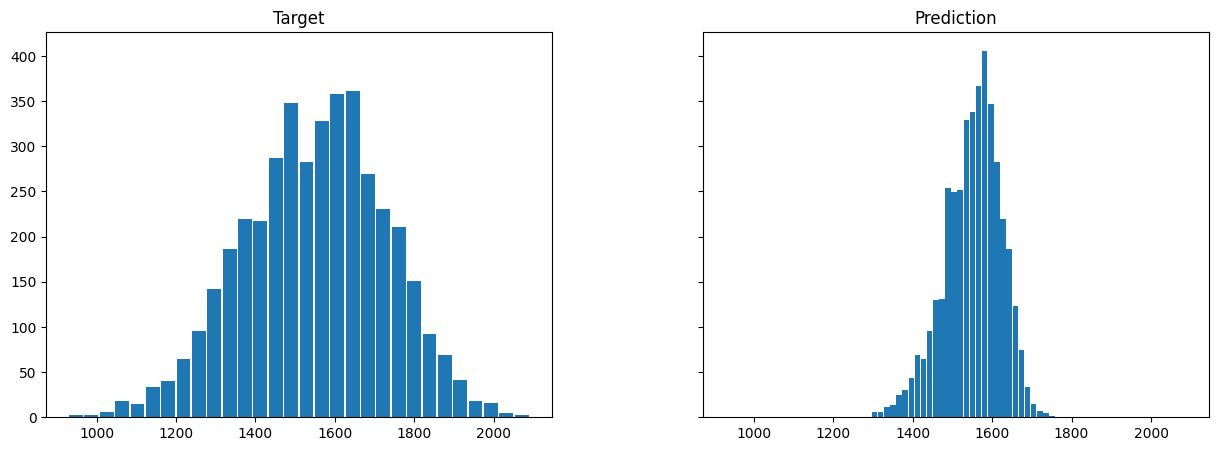

In [200]:
df_valid.hist(column=['Target','Prediction'],bins=30,rwidth=0.9, grid=False, sharex=True, sharey=True,figsize=(15, 5))

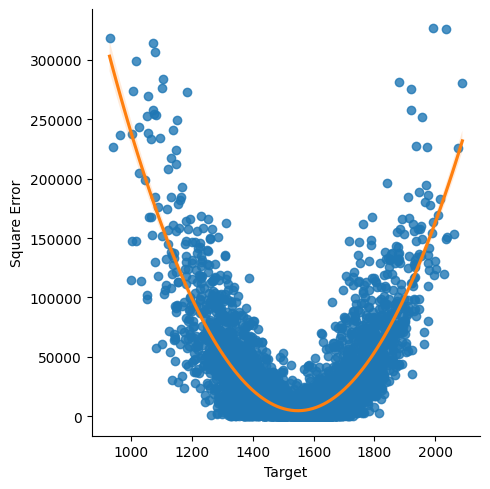

In [202]:
import seaborn as sns
sns.lmplot(x='Target', y='Square Error', data=df_valid, fit_reg=True, order=2, line_kws={"color": "C1"}) 